In [ ]:
import keras
import tensorflow as tf

print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")


Keras version: 3.4.1
TensorFlow version: 2.17.0


In [ ]:
!pip install --upgrade tensorflow


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
import os
import cv2
import dlib
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf  # Import TensorFlow
import shutil
import matplotlib.gridspec as gridspec
import time
import random
from scipy import stats
from sklearn.manifold import TSNE
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception


## **2. Data Preparation**

### **2.1 Data Exploration**

The dataset, obtained from [Kaggle](https://), consists of images of children's faces with 3014 image files in .jpg and .png formats, including two components:

Autistic Dataset: Contains 1507 images of children diagnosed with autism spectrum disorder (ASD).

Non-Autistic Dataset: Contains 1507 images of typically developing individuals who do not have ASD.

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the folder containing the image data on Google Drive
data_dir = '/content/gdrive/MyDrive/AutismDataset/consolidated'
Autistic_path = '/content/gdrive/MyDrive/AutismDataset/consolidated/Autistic'
Non_Autistic_path = '/content/gdrive/MyDrive/AutismDataset/consolidated/Non_Autistic'

# Create a list to store paths to images of autistic children
autistic_images = [os.path.join(data_dir, "Autistic", img) for img in os.listdir(os.path.join(data_dir, "Autistic"))]

# Create a list to store paths to images of non-autistic children
non_autistic_images = [os.path.join(data_dir, "Non_Autistic", img) for img in os.listdir(os.path.join(data_dir, "Non_Autistic"))]


Mounted at /content/gdrive


In [ ]:
# Dataset information
all_images = autistic_images + non_autistic_images
print(f"The dataset contains {len(all_images)} image files:")
print(f"\t {len(autistic_images)} images of autistic children")
print(f"\t {len(non_autistic_images)} images of non-autistic children")


The dataset contains 2939 image files:
	 1470 images of autistic children
	 1469 images of non-autistic children


In [ ]:
def get_image_formats_in_folder(folder_path):
    files = os.listdir(folder_path)
    image_formats = set()
    for file in files:
        # Check the file extension
        _, extension = os.path.splitext(file)

        # Check if it is an image file (additional extensions can be added if needed)
        if extension.lower() in ['.png', '.jpg', '.jpeg', '.gif', '.bmp']:
            image_formats.add(extension.lower())
    return image_formats


In [ ]:
autistic_image_formats = get_image_formats_in_folder(Autistic_path)
print("Image formats in the Autistic folder:")
for format in autistic_image_formats:
    print(format)

# Check and print image formats in the Non_Autistic folder
non_autistic_image_formats = get_image_formats_in_folder(Non_Autistic_path)
print("\nImage formats in the Non_Autistic folder:")
for format in non_autistic_image_formats:
    print(format)


Image formats in the Autistic folder:
.jpg

Image formats in the Non_Autistic folder:
.jpg


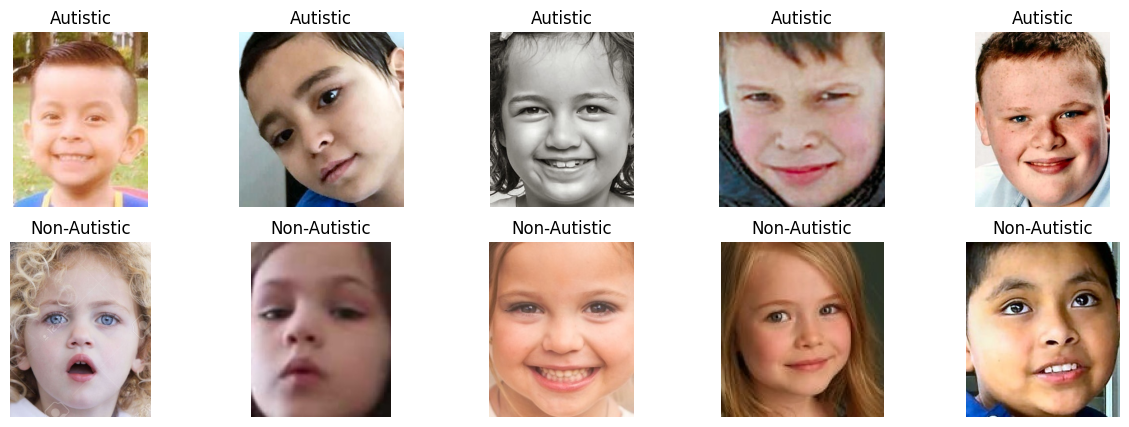

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

num_images_per_group = 5  # Number of images to display per group

# Randomly sample images from each group
autistic_sample = random.sample(autistic_images, num_images_per_group)
non_autistic_sample = random.sample(non_autistic_images, num_images_per_group)

# Create a figure with subplots to display the images
fig, axes = plt.subplots(2, num_images_per_group, figsize=(15, 5))

# Display autistic images
for i, img_path in enumerate(autistic_sample):
    img = mpimg.imread(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Autistic")

# Display non-autistic images
for i, img_path in enumerate(non_autistic_sample):
    img = mpimg.imread(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("Non-Autistic")

# Show the plot
plt.show()


"Visualize the correlation between the two classes of images"

a. Use the t-SNE algorithm to reduce dimensionality and visualize the data


In [ ]:
import cv2
import numpy as np
from sklearn.manifold import TSNE

# Preprocess data before applying the t-SNE algorithm
def process_data_tsne(list_of_images):
    nrows = 150
    ncolumns = 150
    channels = 3
    X = []
    y = []
    for image in list_of_images:
        # Resize the image to the standard size
        img = cv2.imread(image)

        img_resized = cv2.resize(img, (nrows, ncolumns))
        X.append(img_resized.flatten())  # Flatten the image to a 2D array
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)

    X = np.asarray(X)
    y = np.asarray(y)

    return X, y

# Combine the lists of image paths
all_images = autistic_images + non_autistic_images

# Preprocess the images and extract the necessary features
features, labels = process_data_tsne(all_images)

# Perform t-SNE on the features
tsne = TSNE(random_state=42).fit_transform(features)


KeyboardInterrupt: 

In [ ]:
 print(f"Loaded image shape: {img.shape}")


Loaded image shape: (1021, 893, 3)


In [ ]:
print(type(img[0]))
print(img[0])

<class 'numpy.ndarray'>
[[ 85  69  54]
 [ 74  58  43]
 [ 61  45  30]
 ...
 [235 255 254]
 [235 255 254]
 [235 255 254]]




**T-distributed Stochastic Neighbor Embedding (t-SNE)** is a non-linear dimensionality reduction algorithm primarily used to represent high-dimensional data in a lower-dimensional space (typically 2D or 3D) while preserving the similarity between data points as well as possible.



In [ ]:

# Function to display a 3D t-SNE plot
def visualise_tsne_3d(tsne_data, target):
    colour_map = []
    for i in target:
        if i == 1:
            colour_map.append('r')
        else:
            colour_map.append('b')
    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*zip(*tsne), c=colour_map, s=30, alpha=1)
    legenditems = [(plt.Rectangle((0,0),1,1, color=c), "Non_Autistic" if str(i) == '0' else "Autistic") for i,c in enumerate(np.unique(colour_map))]
    plt.legend(*zip(*legenditems))
    plt.show()

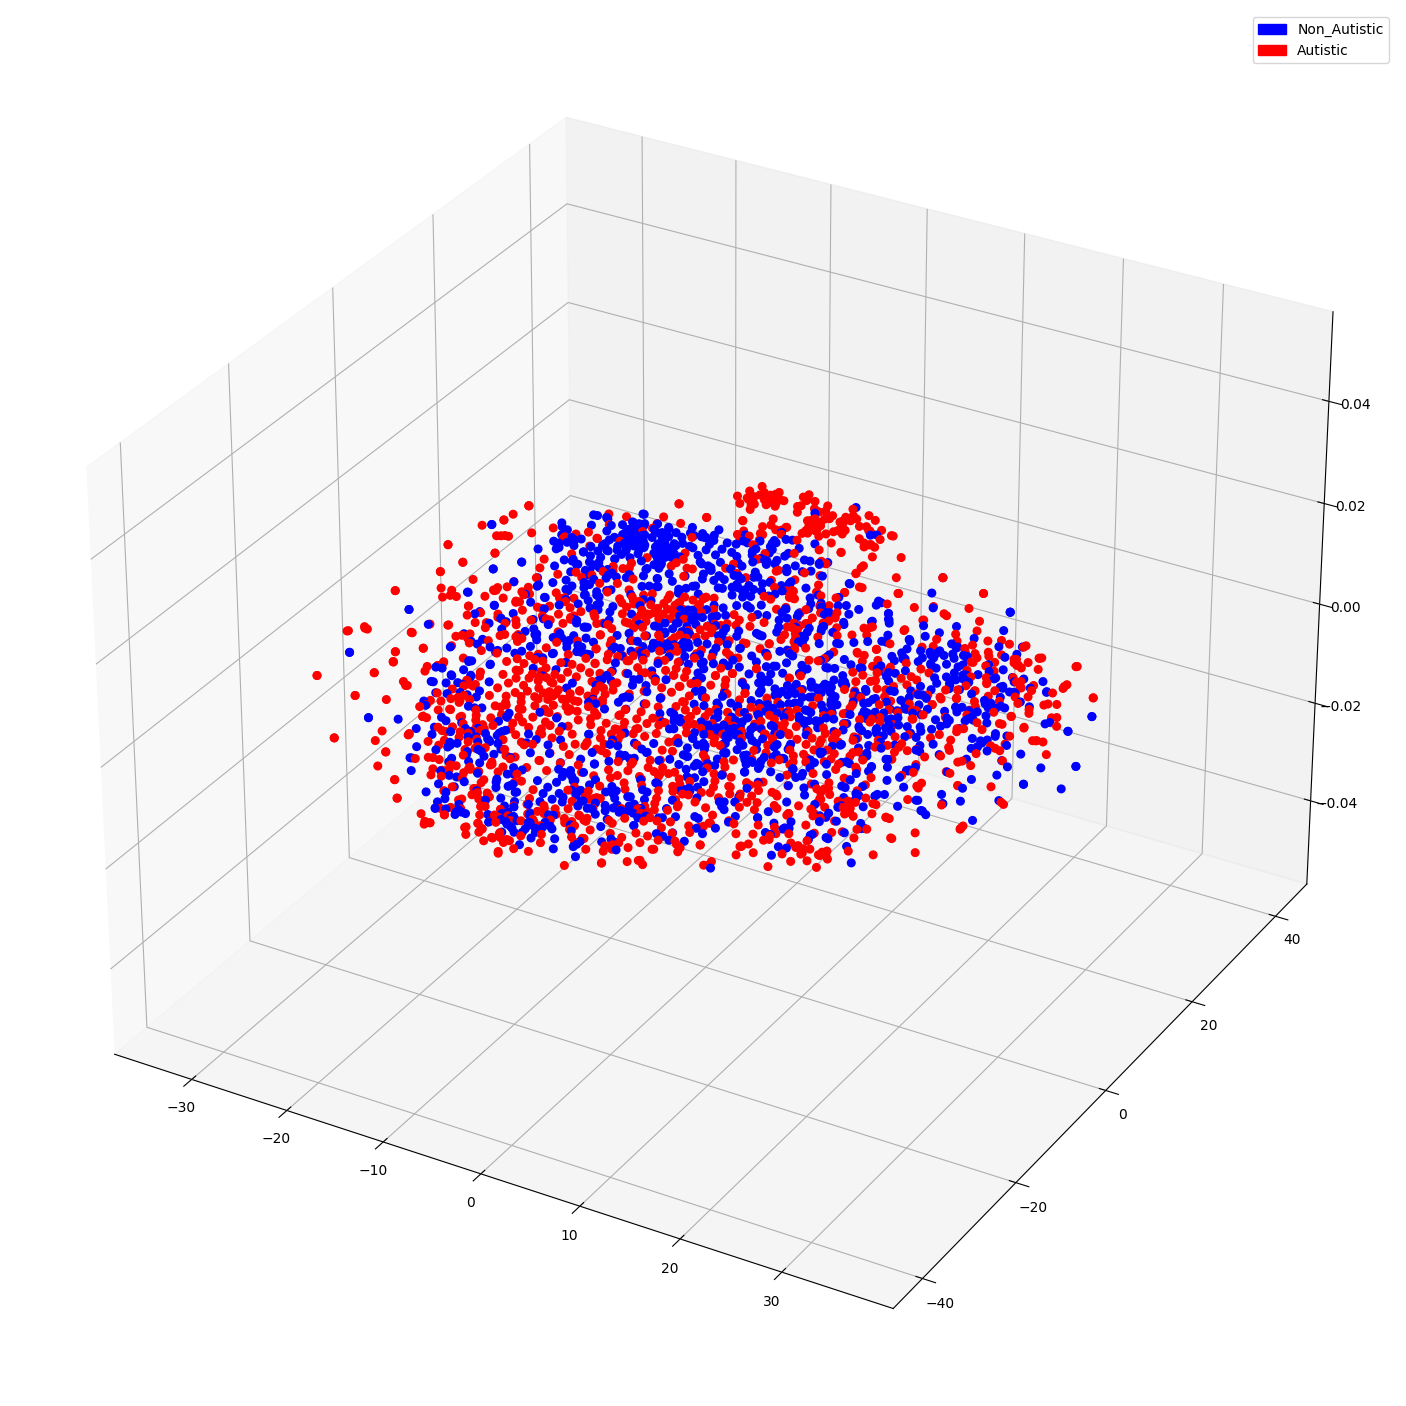

In [ ]:
# Display the results
visualise_tsne_3d(tsne, labels)

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

def visualise_tsne_images(tsne_data, image_paths, labels):
    tx = tsne_data[:, 0]
    ty = tsne_data[:, 1]

    # Normalize the t-SNE data to fit within the image dimensions
    tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))

    width = 4000
    height = 3000
    max_dim = 200

    # Create a blank image to hold the visualized t-SNE data
    full_image = Image.new('RGBA', (width, height))

    for img, x, y, label in zip(image_paths, tx, ty, labels):
        # Open and resize the image
        tile = Image.open(img)
        rs = max(1, tile.width / max_dim, tile.height / max_dim)
        tile = tile.resize((int(tile.width / rs), int(tile.height / rs)), Image.LANCZOS)
        tile_height, tile_width = tile.size

        # Draw a border around the image
        draw = ImageDraw.Draw(tile)
        draw.rectangle((0, 0, tile_height - 1, tile_width - 1), fill=None, outline='blue' if label == 0 else 'red', width=8)

        # Paste the image onto the full image at the normalized coordinates
        full_image.paste(tile, (int((width - max_dim) * x), int((height - max_dim) * (1 - y))), mask=tile.convert('RGBA'))

    # Display the final image
    plt.figure(figsize=(30, 28))
    plt.imshow(full_image)
    plt.show()

# Combine the lists of image paths
all_images = autistic_images + non_autistic_images

# Visualize t-SNE results
visualise_tsne_images(tsne, all_images, labels)


Through this, we can see that the space for this dataset appears to be large, allowing us to visualize more concretely the dataset of over 3000 images. However, the t-SNE technique enables us to begin understanding what is happening within this dataset through clusters of images that are close together or far apart, indicating clear differences within the dataset.

#### **2.2 Data Preprocessing**


Upon examining the dataset, which consists mainly of facial images collected from children with autism spectrum disorder and typically developing children, several limitations have been identified:

1. **Duplicate Images**: Some images may be identical and saved multiple times during the collection process.
2. **Cropping Issues**: Some images are cropped and lack sufficient facial details, or include parts of the body or surrounding scenery.
3. **Blurriness**: Some images are blurred and of low quality.
4. **Inconsistent Sizes**: The images collected are not of the same size.

These limitations can impact the quality of the model. Therefore, appropriate preprocessing is necessary to ensure the accuracy of the model in recognizing and classifying facial images.

In [ ]:
Autistic_path =  "/content/gdrive/MyDrive/AutismDataset/consolidated/Autistic"

Non_Autistic_path = "/content/gdrive/MyDrive/AutismDataset/consolidated/Non_Autistic"

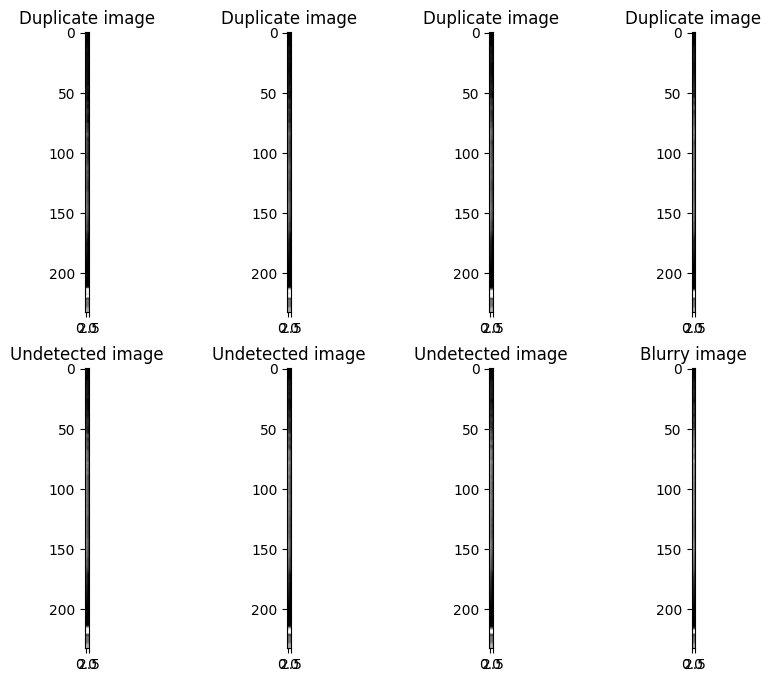

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# List of images and corresponding titles
images = img
titles = ['Duplicate image', 'Duplicate image', 'Duplicate image', 'Duplicate image',
          'Undetected image', 'Undetected image', 'Undetected image', 'Blurry image']

# Create a 2x4 subplot grid
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

# Display the plot
plt.show()


In [ ]:
print(type(images[0]))
print(images[0])


<class 'numpy.ndarray'>
[[ 85  69  54]
 [ 74  58  43]
 [ 61  45  30]
 ...
 [235 255 254]
 [235 255 254]
 [235 255 254]]


In [ ]:
pip install imageio


## **a. Remove Duplicate Images**

Use a hash table to compare and find duplicate images in the dataset.


In [ ]:
import cv2
import os

# Function to use a hash table to compare images
def dhash(image, hashSize=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2**i for (i, v) in enumerate(diff.flatten()) if v])

# Function to find duplicate images
def find_duplicate_images(directory):
    hashes = {}
    duplicates = []

    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            img_path = os.path.join(directory, filename)
            image = cv2.imread(img_path)
            h = dhash(image)
            p = hashes.get(h, [])
            p.append(img_path)
            hashes[h] = p

    for key, paths in hashes.items():
        if len(paths) > 1:
            duplicates.append(paths)

    return duplicates


Processing the dataset

In [ ]:
# Find duplicate images in Autistic dataset
Autistic_duplicate_images = find_duplicate_images(Autistic_path)

if Autistic_duplicate_images:
    print("Duplicate images found:")
    for paths in Autistic_duplicate_images:
        paths = [os.path.basename(f) for f in paths]
        print(f"Duplicates: {paths}")
else:
    print("No duplicate images found.")


No duplicate images found.


In [ ]:
# Find duplicate images in Non_Autistic dataset
Non_Autistic_duplicate_images = find_duplicate_images(Non_Autistic_path)

if Non_Autistic_duplicate_images:
    print("Duplicate images found:")
    for paths in Non_Autistic_duplicate_images:
        paths = [os.path.basename(f) for f in paths]
        print(f"Duplicates: {paths}")
else:
    print("No duplicate images found.")


No duplicate images found.


In [ ]:
# Combine duplicate images from both Non_Autistic and Autistic datasets
duplicate_images = Non_Autistic_duplicate_images + Autistic_duplicate_images

for paths in duplicate_images:
    # Keep the first image and delete the subsequent duplicate images
    for img_path in paths[1:]:
        os.remove(img_path)


After removing the duplicate images, the results obtained are:

In [ ]:
autistic_images = [os.path.join(Autistic_path, img) for img in os.listdir(Autistic_path)]
non_autistic_images = [os.path.join(Non_Autistic_path, img) for img in os.listdir(Non_Autistic_path)]

print('Number of images remaining after processing:')
print('Autistic: ', len(autistic_images))
print('Non-autistic: ', len(non_autistic_images))


Number of images remaining after processing:
Autistic:  1470
Non-autistic:  1469


# b. Remove images with undetectable faces and standardize image sizes

Use Haar CascadeClassifier in OpenCV to assist with face detection and identifying features such as eyes and mouth.

In [ ]:
# Load Haar Cascade Classifiers for face, eye, and mouth detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')


It is observed that this dataset consists of facial images, so most of the images will reach the detection threshold, resulting in empty returns when detecting faces. Therefore, for images that include external elements or parts of the body, it is necessary to crop the face to facilitate easier recognition.

After completing the data cleaning process, we obtained a new dataset as follows:

In [ ]:
# Function to crop and select the face region from an image
def get_cropped_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.3, minNeighbors=5)
            if len(eyes) >= 2:
                return roi_color
    else:
        eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        mouth = mouth_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        if len(eyes) >= 2 and len(mouth) >= 1:
            return img
    return None


In [ ]:
# Function to crop face images and standardize the size of detectable images into a new folder
def save_cropped_faces(image_paths, output_folder):
    undetected_images = []

    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_path in image_paths:
        cropped_img = get_cropped_image(img_path)

        if cropped_img is not None:
            file_name = os.path.basename(img_path)
            output_path = os.path.join(output_folder, file_name)

            # Resize the cropped image to a uniform size
            cropped_img = cv2.resize(cropped_img, (224, 224))
            cv2.imwrite(output_path, cropped_img)
        else:
            undetected_images.append(os.path.basename(img_path))

    return undetected_images


**Process the images in the folders**

In [ ]:
Au_filenames = [f for f in os.listdir(Autistic_path) if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
Non_Au_filenames = [f for f in os.listdir(Non_Autistic_path) if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

Autistic_image_paths = [os.path.join(Autistic_path, filename) for filename in Au_filenames]
Non_Autistic_image_paths = [os.path.join(Non_Autistic_path, filename) for filename in Non_Au_filenames]


In [ ]:
output_folder = "/content/gdrive/MyDrive/Project_Python_DS/cleanData/Autistic"
Autistic_undetected_images = []
Autistic_undetected_images = save_cropped_faces(Autistic_image_paths, output_folder)

KeyboardInterrupt: 

In [ ]:
output_folder = "/content/gdrive/MyDrive/Project_Python_DS/cleanData/Non_Autistic"
Non_Autistic_undetected_images = []
Non_Autistic_undetected_images = save_cropped_faces(Non_Autistic_image_paths, output_folder)

## **3. Data Exploration and Analysis (EDA):**

##### **3.1 Scientific Basis for Analysis:**

According to researchers **Hammond, P.; Forster-Gibson, C.; Chudley, AE; Allanson, JE; Hutton, TJ; Farrell, SA; McKenzie, J.; Holden, JJA** in their paper **"Face–brain asymmetry in autism spectrum disorders"**, it was found that:

They used dense surface modeling techniques to compare the facial morphology of 72 boys with ASD and 128 first-degree relatives with 254 unrelated controls. The pattern-matching algorithms were able to distinguish between the faces of boys with ASD and those of age-matched controls (AUC=0.82) and also between the faces of unaffected mothers of children with ASD and age-matched female controls (AUC=0.76). They found significant asymmetry in the faces of boys with ASD (P < 0.01), particularly in depth in the upper and periorbital regions of the right frontal hemisphere. Unaffected mothers of children with ASD exhibited significant facial asymmetry similar to, but more pronounced than, the matched controls (P < 0.03), and notably, showed vertical asymmetry in the periorbital region.

In contrast, unaffected fathers of children with ASD did not show significant facial asymmetry compared to the control group. Two-thirds of unaffected male siblings tested were classified as undetectable due to their faces resembling those of unrelated boys with ASD more than unrelated control boys. These unaffected male siblings and two smaller groups of girls with ASD and unaffected sisters all exhibited overall directional asymmetry, but did not achieve statistical significance in two-tailed tests of their individual ASD and matched control groups. They concluded that the previously identified right-sided frontal asymmetry in boys with ASD might explain their facial asymmetry through the direct impact of brain development. The atypical facial asymmetry in unaffected mothers of children with ASD requires further research on the brain before similar explanations can be provided. Another non-mutually exclusive explanation is the simultaneous and parallel impact on facial and brain development by genetic factors. Both possibilities suggest the need for coordinated research on facial and brain samples from ASD individuals and their first-degree relatives, especially in unaffected mothers, as their atypical facial asymmetry indicates that ASD susceptibility may arise from maternal genes.

**3.3 Feature Extraction for Data Analysis**

**Extracting Age and Gender**

In [ ]:
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS

Downloading...
From (original): https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
From (redirected): https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS&confirm=t&uuid=8355aad6-ede1-4e94-8e83-b5d708f5594b
To: /content/modelNweight.zip
100% 86.2M/86.2M [00:01<00:00, 80.5MB/s]


In [ ]:
!unzip modelNweight.zip

Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [ ]:
# Paths to the model files for face detection, age estimation, and gender classification

import cv2
faceProto = "modelNweight/opencv_face_detector.pbtxt"  # Path to the configuration file for face detection
faceModel = "modelNweight/opencv_face_detector_uint8.pb"  # Path to the trained model file for face detection

ageProto = "modelNweight/age_deploy.prototxt"  # Path to the configuration file for age estimation
ageModel = "modelNweight/age_net.caffemodel"  # Path to the trained model file for age estimation

genderProto = "modelNweight/gender_deploy.prototxt"  # Path to the configuration file for gender classification
genderModel = "modelNweight/gender_net.caffemodel"  # Path to the trained model file for gender classification

# Mean values used for normalization
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

# Age and gender categories
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']  # List of age ranges
genderList = ['Male', 'Female']  # List of gender categories

# Load the networks for age and gender classification, and face detection
ageNet = cv2.dnn.readNet(ageModel, ageProto)  # Load the age estimation network
genderNet = cv2.dnn.readNet(genderModel, genderProto)  # Load the gender classification network
faceNet = cv2.dnn.readNet(faceModel, faceProto)  # Load the face detection network

padding = 20  # Padding size used for cropping images


In [ ]:
def getFaceBox(net, frame, conf_threshold=0.7):
    """
    Detect faces in an image and draw bounding boxes around them.

    Parameters:
    - net: The face detection network.
    - frame: The input image.
    - conf_threshold: Confidence threshold for detecting faces.

    Returns:
    - frameOpencvDnn: The image with bounding boxes drawn around detected faces.
    - bboxes: List of bounding boxes for detected faces.
    """
    frameOpencvDnn = frame.copy()  # Create a copy of the frame
    frameHeight = frameOpencvDnn.shape[0]  # Get the height of the frame
    frameWidth = frameOpencvDnn.shape[1]  # Get the width of the frame

    # Prepare the image for face detection
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)  # Set the input for the network
    detections = net.forward()  # Perform forward pass to get detections
    bboxes = []  # List to store bounding boxes

    # Process detections
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:  # Check if the detection is above the confidence threshold
            x1 = int(detections[0, 0, i, 3] * frameWidth)  # Calculate x1 coordinate
            y1 = int(detections[0, 0, i, 4] * frameHeight)  # Calculate y1 coordinate
            x2 = int(detections[0, 0, i, 5] * frameWidth)  # Calculate x2 coordinate
            y2 = int(detections[0, 0, i, 6] * frameHeight)  # Calculate y2 coordinate
            bboxes.append([x1, y1, x2, y2])  # Add bounding box to list
            # Draw bounding box on the image
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes  # Return the image with bounding boxes and list of bounding boxes

# Function to detect age and gender
def age_gender_detector(frame):
    """
    Detect age and gender from a frame.

    Parameters:
    - frame: The input image.

    Returns:
    - age: Detected age group.
    - gender: Detected gender.
    """
    t = time.time()  # Record start time
    frameFace, bboxes = getFaceBox(faceNet, frame)  # Get face bounding boxes

    for bbox in bboxes:
        face = frame[max(0, bbox[1] - padding):min(bbox[3] + padding, frame.shape[0] - 1),
                     max(0, bbox[0] - padding):min(bbox[2] + padding, frame.shape[1] - 1)]

        if not face.size or face.shape[0] == 0 or face.shape[1] == 0:
            continue  # Skip if face region is invalid

        # Prepare face image for age and gender detection
        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        # Predict age
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]  # Get the predicted age group

        # Predict gender
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]  # Get the predicted gender

    return age, gender  # Return the detected age and gender


#  **Extract Detailed Facial Features**

With these facial features, it becomes easier to analyze and identify some differences between typical individuals and those with autism spectrum disorder (ASD) through characteristics such as:

+ The distance between the eyes.
+ The height of the upper half of the face.
+ The height of the middle face.
+ The width of the mouth.
+ The length of the philtrum.

It is observed that there are differences between the distances between facial features in profile and frontal views. When the face is in profile, parts of the face are obscured, making the distances obtained less accurate when the dataset includes both profile and frontal views.

To address this, the ratio of the distances to the corresponding width or height of the face is calculated (e.g., the width of the mouth compared to the width of the face). Using ratios of these features relative to the overall face dimensions is an effective way to mitigate the influence of absolute size and ensure consistency when processing both profile and frontal faces. However, since the number of profile faces in the dataset is not significant and to provide clearer and more specific visualizations of each distance, the team chose to extract these distances only from frontal faces.

**Extracting feature distances for frontal faces:**

Using the facial landmark detector from dlib, which implements the algorithm described in the paper "One Millisecond Face Alignment with an Ensemble of Regression Trees" by Kazemi and Sullivan (2014). This facial landmark detector identifies 81 key points with (x, y) coordinates that make up the human face, as shown in the image below.

Identify front-facing faces.

In [ ]:
# Calculate the angle between two vectors
def calculate_angle(vector1, vector2):
    dot_product = sum(a * b for a, b in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(a ** 2 for a in vector1))
    magnitude2 = math.sqrt(sum(b ** 2 for b in vector2))
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    angle = math.degrees(math.acos(cosine_similarity))
    return angle

# Calculate the tilt of the face
def calculate_face_orientation(landmarks):
    # Vectors representing the left and right eyes
    vector1 = [landmarks.part(27).x - landmarks.part(30).x, landmarks.part(27).y - landmarks.part(30).y] # corresponds to the nose bridge
    vector2 = [landmarks.part(31).x - landmarks.part(35).x, landmarks.part(31).y - landmarks.part(35).y] # corresponds to the line connecting the two nostrils
    # Calculate the angle between the two vectors
    angle = calculate_angle(vector1, vector2)

    return angle


In [ ]:
Autistic_frontface = []
for img_path in Autistic_image_paths:
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/gdrive/MyDrive/AutismDataset/shape_predictor_81_face_landmarks.dat")

    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        face_orientation = calculate_face_orientation(landmarks)

        if face_orientation >= 80 and face_orientation <= 100:
            Autistic_frontface.append(os.path.basename(img_path))

Autistic_frontface_path = [os.path.join(Autistic_path, filename) for filename in Autistic_frontface]


In [ ]:
Non_Autistic_frontface = []
for img_path in Non_Autistic_image_paths:
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/gdrive/MyDrive/AutismDataset/shape_predictor_81_face_landmarks.dat")

    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        face_orientation = calculate_face_orientation(landmarks)

        if face_orientation >= 80 and face_orientation <= 100:
            Non_Autistic_frontface.append(os.path.basename(img_path))

Non_Autistic_frontface_path = [os.path.join(Non_Autistic_path, filename) for filename in Non_Autistic_frontface]


**Create DataFrame and Export to CSV File**

In [ ]:
# Distance between two points on the face
def compute_distance(landmarks, point1, point2):
    x1, y1 = landmarks.part(point1).x, landmarks.part(point1).y
    x2, y2 = landmarks.part(point2).x, landmarks.part(point2).y
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

# Normalize image by converting pixel values to the range 0-1
def normalize_image(image):
    normalized_image = image.astype(np.float32) / 255.0
    return normalized_image


In [ ]:
def extract_facial_features(image_path):
    # Initialize face detector and landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/gdrive/MyDrive/AutismDataset/shape_predictor_81_face_landmarks.dat")

    # Read and preprocess the image
    image = cv2.imread(image_path)
    img_name = os.path.basename(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect age and gender
    age_gender = age_gender_detector(image)
    image = normalize_image(image)

    # Detect faces in the image
    faces = detector(gray)

    # Initialize dictionary to store facial features
    features_dict = {
        "Image_Name": img_name,
        "Age": age_gender[0],
        "Gender": age_gender[1],
        "Eyes_Distance": None,
        "Upper_Face": None,
        "Middle_Face": None,
        "Mouth_Width": None,
        "Philtrum_Length": None
    }

    # Compute facial features for each detected face
    for face in faces:
        landmarks = predictor(gray, face)

        # Calculate distances between facial landmarks
        eye_distance = compute_distance(landmarks, 39, 42)
        upper_face_length = compute_distance(landmarks, 17, 68)
        mid_face_height = compute_distance(landmarks, 33, 21)
        mouth_width = compute_distance(landmarks, 51, 33)
        philtrum_length = compute_distance(landmarks, 54, 48)

        # Store computed features in the dictionary
        features_dict["Eyes_Distance"] = eye_distance
        features_dict["Upper_Face"] = upper_face_length
        features_dict["Middle_Face"] = mid_face_height
        features_dict["Mouth_Width"] = mouth_width
        features_dict["Philtrum_Length"] = philtrum_length

    return features_dict


In [ ]:
import pandas as pd

In [ ]:
import pandas as pd

# Initialize an empty DataFrame with specified columns
df_Autistic = pd.DataFrame(columns=["Image_Name", "Age", "Gender", "Eyes_Distance", "Upper_Face", "Middle_Face", "Mouth_Width", "Philtrum_Length"])

# Assuming Autistic_frontface_path is a list of image paths
for image_path in Autistic_frontface_path:
    features_dict = extract_facial_features(image_path)
    if features_dict is not None:
        # Convert the dictionary to a DataFrame
        features_df = pd.DataFrame([features_dict])

        # Concatenate the new DataFrame with the existing DataFrame
        df_Autistic = pd.concat([df_Autistic, features_df], ignore_index=True)

# Specify the path to save the DataFrame
path = "/content/gdrive/MyDrive/Project_Python_DS/cleanData/Autistic.csv"
df_Autistic.to_csv(path, index=False)

<ipython-input-44-53d38c6fe7c5>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_Autistic = pd.concat([df_Autistic, features_df], ignore_index=True)


In [ ]:

import pandas as pd

# Initialize an empty DataFrame with specified columns
df_Non_Autistic = pd.DataFrame(columns=["Image_Name", "Age", "Gender", "Eyes_Distance", "Upper_Face", "Middle_Face", "Mouth_Width", "Philtrum_Length"])

# Assuming Non_Autistic_frontface_path is a list of image paths
for image_path in Non_Autistic_frontface_path:
    features_dict = extract_facial_features(image_path)
    if features_dict is not None:
        # Convert the dictionary to a DataFrame
        features_df = pd.DataFrame([features_dict])

        # Concatenate the new DataFrame with the existing DataFrame
        df_Non_Autistic = pd.concat([df_Non_Autistic, features_df], ignore_index=True)

# Specify the path to save the DataFrame
path = "/content/gdrive/MyDrive/Project_Python_DS/cleanData/Non_Autistic.csv"
df_Non_Autistic.to_csv(path, index=False)

<ipython-input-45-d84f275ae069>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_Non_Autistic = pd.concat([df_Non_Autistic, features_df], ignore_index=True)


# **3.4 Data Analysis (EDA)**

a. **Statistical Data**

In [ ]:
# Read data from CSV files
autistic_data = pd.read_csv('/content/gdrive/MyDrive/Project_Python_DS/cleanData/Autistic.csv')
non_autistic_data = pd.read_csv('/content/gdrive/MyDrive/Project_Python_DS/cleanData/Non_Autistic.csv')
non_autistic_data = non_autistic_data.dropna()
autistic_data = autistic_data.dropna()



FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/Project_Python_DS/cleanData/Autistic.csv'

In [ ]:
autistic_data.head(5)

,Image_Name,Age,Gender,Eyes_Distance,Upper_Face,Middle_Face,Mouth_Width,Philtrum_Length
0,0483.jpg,(25-32),Female,69.354164,92.021737,120.904921,24.020824,119.603512
1,0729.jpg,(4-6),Female,61.294372,72.173402,87.281155,22.000000,74.545288
2,0704.jpg,(25-32),Male,31.144823,43.000000,52.497619,11.000000,47.169906
3,0468.jpg,(25-32),Male,113.534136,142.337627,188.679623,46.389654,151.327460
4,0392.jpg,(8-12),Male,50.635956,78.000000,89.498603,17.464249,79.906195


In [ ]:
non_autistic_data.head(5)

,Image_Name,Age,Gender,Eyes_Distance,Upper_Face,Middle_Face,Mouth_Width,Philtrum_Length
0,0362.jpg,(25-32),Female,52.497619,76.485293,94.021274,16.155494,96.166522
1,0295.jpg,(25-32),Female,64.195015,89.050547,110.113578,24.515301,85.234969
2,0208.jpg,(8-12),Female,81.123363,109.018347,133.544000,26.076810,126.657017
3,0556.jpg,(4-6),Female,222.611770,304.014802,368.419598,58.077534,330.945615
4,0511.jpg,(0-2),Male,137.295302,190.601679,226.108381,26.476405,244.983673


In [ ]:
# Statistical description of features
print("\nStatistical description of autistic data:")
print(autistic_data.describe())
print("\nStatistical description of non-autistic data:")
print(non_autistic_data.describe())



Statistical description of autistic data:
       Eyes_Distance   Upper_Face  Middle_Face  Mouth_Width  Philtrum_Length
count    1213.000000  1213.000000  1213.000000  1213.000000      1213.000000
mean       69.285505    92.671902   115.284953    23.250764       106.357674
std        42.260676    57.000609    69.986128    14.969870        67.248737
min        16.155494    21.470911    29.427878     5.099020        20.615528
25%        44.000000    58.034473    72.034714    14.035669        66.760767
50%        57.314920    77.000000    96.130120    19.026298        88.141931
75%        81.024688   107.168092   132.094663    27.166155       125.574679
max       572.420300   782.163666   841.189634   149.682998      1015.238396

Statistical description of non-autistic data:
       Eyes_Distance   Upper_Face  Middle_Face  Mouth_Width  Philtrum_Length
count    1306.000000  1306.000000  1306.000000  1306.000000      1306.000000
mean       70.847538    94.788222   117.016238    23.635931    

**b. Data Visualization**

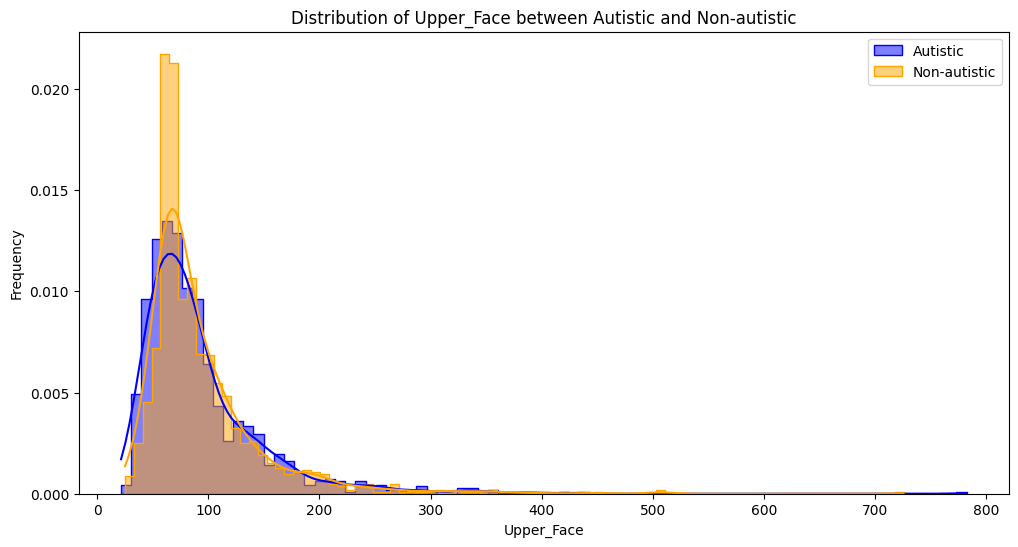

In [ ]:
# Feature of interest
feature_of_interest = 'Upper_Face'

# Compare the distribution of the feature between the two groups
plt.figure(figsize=(12, 6))
sns.histplot(autistic_data[feature_of_interest], label='Autistic', kde=True, element='step', stat='density', common_norm=False, color='blue', alpha=0.5)
sns.histplot(non_autistic_data[feature_of_interest], label='Non-autistic', kde=True, element='step', stat='density', common_norm=False, color='orange', alpha=0.5)
plt.title(f'Distribution of {feature_of_interest} between Autistic and Non-autistic')
plt.xlabel(feature_of_interest)
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
# Create Series containing Upper_Face data from the autistic dataset
Upper_Face_autistic = autistic_data['Upper_Face']
Upper_Face_non_autistic = non_autistic_data['Upper_Face']

# Perform a t-test to compare the means of Upper_Face between the two groups
t_statistic, p_value = stats.ttest_ind(Upper_Face_autistic, Upper_Face_non_autistic, alternative='greater')

# Print results
print("t-statistic value:", t_statistic)
print("p-value:", p_value)

# Hypothesis testing
alpha = 0.05
if p_value < alpha:
    print("There is enough evidence to conclude that the Upper_Face measurement in the autistic group is greater than that in the non-autistic group with 95% confidence.")
else:
    print("There is not enough evidence to conclude that the Upper_Face measurement in the autistic group is greater than that in the non-autistic group with 95% confidence.")


t-statistic value: -0.9257354267400592
p-value: 0.8226638797791249
There is not enough evidence to conclude that the Upper_Face measurement in the autistic group is greater than that in the non-autistic group with 95% confidence.


With just the chart, it is difficult to discern the difference between autism and non-autism. However, with this mean test, we can see that difference.

Perform visualization and testing with the remaining distances.

t-statistic value: -0.6166013707617041
p-value: 0.26877672707679023
There is not enough evidence to suggest that the Middle_Face of the `autistic_data` group is smaller than that of the `non_autistic_data` group with 95% confidence.


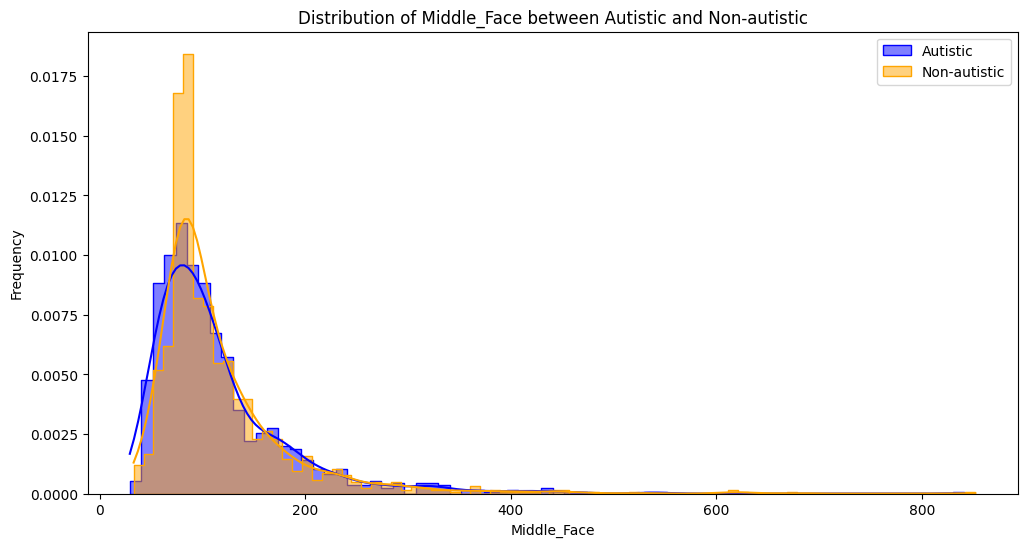

In [ ]:
# Create a Series containing data about Middle_Face from the autistic dataset
Middle_Face_autistic = autistic_data['Middle_Face']
Middle_Face_non_autistic = non_autistic_data['Middle_Face']

# Use independent Student's t-test
t_statistic, p_value = stats.ttest_ind(Middle_Face_autistic, Middle_Face_non_autistic, alternative='less')

# Print results
print("t-statistic value:", t_statistic)
print("p-value:", p_value)

# Hypothesis testing
alpha = 0.05
if p_value < alpha:
    print("There is sufficient evidence to suggest that the Middle_Face of the `autistic_data` group is smaller than that of the `non_autistic_data` group with 95% confidence.")
else:
    print("There is not enough evidence to suggest that the Middle_Face of the `autistic_data` group is smaller than that of the `non_autistic_data` group with 95% confidence.")

# Analyze a specific feature, for example: middle face
feature_of_interest = 'Middle_Face'

# Compare the distribution of the feature between the two groups
plt.figure(figsize=(12, 6))
sns.histplot(autistic_data[feature_of_interest], label='Autistic', kde=True, element='step', stat='density', common_norm=False, color='blue', alpha=0.5)
sns.histplot(non_autistic_data[feature_of_interest], label='Non-autistic', kde=True, element='step', stat='density', common_norm=False, color='orange', alpha=0.5)
plt.title(f'Distribution of {feature_of_interest} between Autistic and Non-autistic')
plt.xlabel(feature_of_interest)
plt.ylabel('Frequency')
plt.legend()
plt.show()


t-statistic value: -0.6397874516263784
p-value: 0.7388154903104018
There is not enough evidence to suggest that the Mouth_Width of the `autistic_data` group is larger than that of the `non_autistic_data` group with 95% confidence.


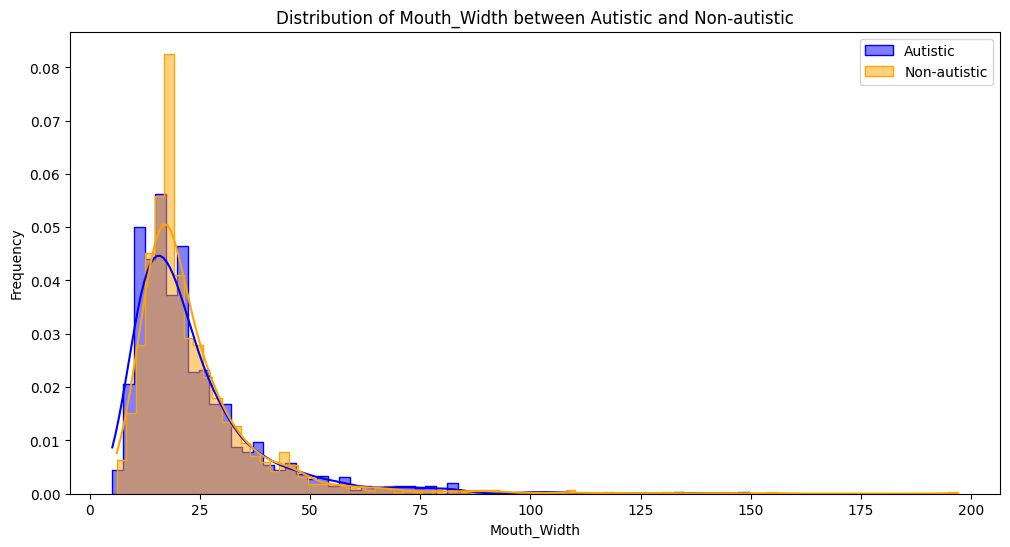

In [ ]:
# Create a Series containing data about Mouth_Width from the autistic dataset
Mouth_Width_autistic = autistic_data['Mouth_Width']
Mouth_Width_non_autistic = non_autistic_data['Mouth_Width']

# Use independent Student's t-test
t_statistic, p_value = stats.ttest_ind(Mouth_Width_autistic, Mouth_Width_non_autistic, alternative='greater')

# Print results
print("t-statistic value:", t_statistic)
print("p-value:", p_value)

# Hypothesis testing
alpha = 0.05
if p_value < alpha:
    print("There is sufficient evidence to suggest that the Mouth_Width of the `autistic_data` group is larger than that of the `non_autistic_data` group with 95% confidence.")
else:
    print("There is not enough evidence to suggest that the Mouth_Width of the `autistic_data` group is larger than that of the `non_autistic_data` group with 95% confidence.")

# Analyze a specific feature, for example: mouth width
feature_of_interest = 'Mouth_Width'

# Compare the distribution of the feature between the two groups
plt.figure(figsize=(12, 6))
sns.histplot(autistic_data[feature_of_interest], label='Autistic', kde=True, element='step', stat='density', common_norm=False, color='blue', alpha=0.5)
sns.histplot(non_autistic_data[feature_of_interest], label='Non-autistic', kde=True, element='step', stat='density', common_norm=False, color='orange', alpha=0.5)
plt.title(f'Distribution of {feature_of_interest} between Autistic and Non-autistic')
plt.xlabel(feature_of_interest)
plt.ylabel('Frequency')
plt.legend()
plt.show()


t-statistic value: -0.9172439682763042
p-value: 0.8204486552196408
There is not enough evidence to suggest that the Eyes_Distance of the `autistic_data` group is greater than that of the `non_autistic_data` group with 95% confidence.


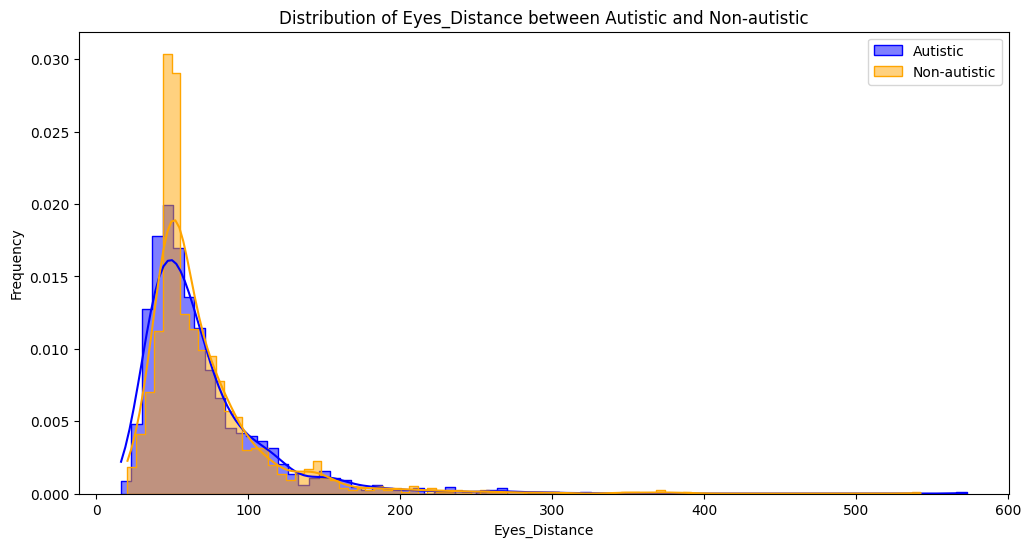

In [ ]:
# Create a Series containing data about Eyes_Distance from the autistic dataset
eyes_distance_autistic = autistic_data['Eyes_Distance']
eyes_distance_non_autistic = non_autistic_data['Eyes_Distance']

# Use independent Student's t-test
t_statistic, p_value = stats.ttest_ind(eyes_distance_autistic, eyes_distance_non_autistic, alternative='greater')

# Print results
print("t-statistic value:", t_statistic)
print("p-value:", p_value)

# Hypothesis testing
alpha = 0.05
if p_value < alpha:
    print("There is sufficient evidence to suggest that the Eyes_Distance of the `autistic_data` group is greater than that of the `non_autistic_data` group with 95% confidence.")
else:
    print("There is not enough evidence to suggest that the Eyes_Distance of the `autistic_data` group is greater than that of the `non_autistic_data` group with 95% confidence.")

# Analyze a specific feature, for example: eye distance
feature_of_interest = 'Eyes_Distance'

# Compare the distribution of the feature between the two groups
plt.figure(figsize=(12, 6))
sns.histplot(autistic_data[feature_of_interest], label='Autistic', kde=True, element='step', stat='density', common_norm=False, color='blue', alpha=0.5)
sns.histplot(non_autistic_data[feature_of_interest], label='Non-autistic', kde=True, element='step', stat='density', common_norm=False, color='orange', alpha=0.5)
plt.title(f'Distribution of {feature_of_interest} between Autistic and Non-autistic')
plt.xlabel(feature_of_interest)
plt.ylabel('Frequency')
plt.legend()
plt.show()


t-statistic value: 0.3393876284927877
p-value: 0.3671730256706631
There is not enough evidence to suggest that the Philtrum_Length in the `autistic_data` group is greater than in the `non_autistic_data` group with 95% confidence.


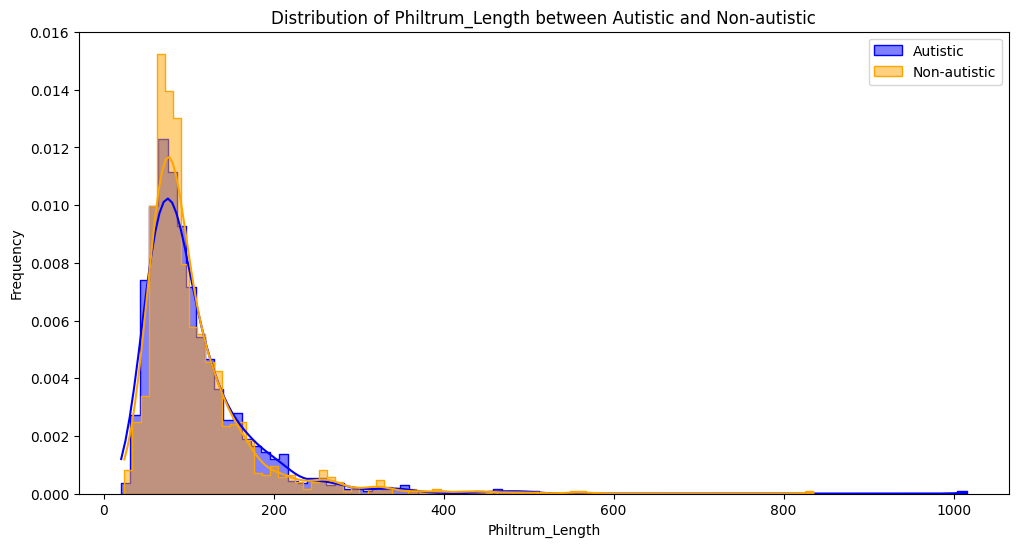

In [ ]:
# Create a Series containing data about Philtrum_Length from the autistic dataset
Philtrum_Length_autistic = autistic_data['Philtrum_Length']
Philtrum_Length_non_autistic = non_autistic_data['Philtrum_Length']

# Use independent Student's t-test
t_statistic, p_value = stats.ttest_ind(Philtrum_Length_autistic, Philtrum_Length_non_autistic, alternative='greater')

# Print results
print("t-statistic value:", t_statistic)
print("p-value:", p_value)

# Hypothesis testing
alpha = 0.05
if p_value < alpha:
    print("There is sufficient evidence to suggest that the Philtrum_Length in the `autistic_data` group is greater than in the `non_autistic_data` group with 95% confidence.")
else:
    print("There is not enough evidence to suggest that the Philtrum_Length in the `autistic_data` group is greater than in the `non_autistic_data` group with 95% confidence.")

# Analyze a specific feature, for example: philtrum length
feature_of_interest = 'Philtrum_Length'

# Compare the distribution of the feature between the two groups
plt.figure(figsize=(12, 6))
sns.histplot(autistic_data[feature_of_interest], label='Autistic', kde=True, element='step', stat='density', common_norm=False, color='blue', alpha=0.5)
sns.histplot(non_autistic_data[feature_of_interest], label='Non-autistic', kde=True, element='step', stat='density', common_norm=False, color='orange', alpha=0.5)
plt.title(f'Distribution of {feature_of_interest} between Autistic and Non-autistic')
plt.xlabel(feature_of_interest)
plt.ylabel('Frequency')
plt.legend()
plt.show()


=> **From this, we can somewhat visualize the facial characteristics of children with ASD as having a wider upper face, a shorter mid-face, wider eyes, a wider mouth, and a broader philtrum. These are some common facial features observed in children with ASD.**

# **4. Model**

### **4.1 Machine Learning Model for Feature Extraction Data**

#### **4.1.1 Merging Data and Extracting Labels**

In [ ]:
autistic_data['label'] = 0
non_autistic_data['label'] = 1
# Merge the two DataFrames into one
merged_data = pd.concat([autistic_data, non_autistic_data], ignore_index=True)

# Print the first few rows of the new DataFrame
data = merged_data.dropna()
X = data[['Eyes_Distance', 'Upper_Face', 'Middle_Face', 'Mouth_Width', 'Philtrum_Length']]
y = data['label']


NameError: name 'autistic_data' is not defined

#### **4.1.1 Splitting the data into train and test sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'X' is not defined

In [ ]:
X_train.shape

NameError: name 'X_train' is not defined

In [ ]:
y_train.shape

(2015,)

#### **4.1.2 Training the model**

The XGBoost model offers high predictive accuracy and is nearly 10 times faster than other gradient boosting techniques. It also includes several regularization parameters that help reduce overfitting and improve overall performance. As a result, it is often referred to as a regularized boosting technique.


In [ ]:
# Initialize the XGBoost Classifier model
model = xgb.XGBClassifier(
    objective="multi:softmax",  # Specifies the learning task and corresponding objective. 'multi:softmax' is for multi-class classification.
    num_class=2,                # The number of classes. Since it's binary classification, this is set to 2.
    seed=42,                    # Random seed for reproducibility.
    n_estimators=200,           # Number of boosting rounds (trees).
    learning_rate=0.1,          # Step size shrinkage used to prevent overfitting.
    max_depth=20,               # Maximum depth of a tree. Higher values increase model complexity.
    min_child_weight=1,         # Minimum sum of instance weight needed in a child. Controls overfitting.
    subsample=1.0,              # Fraction of samples to be used for each tree. Lower values prevent overfitting.
    colsample_bytree=1.0,       # Fraction of features to be used for each tree. Controls model complexity.
    gamma=0,                    # Minimum loss reduction required to make a further partition. Controls tree pruning.
    reg_alpha=0,                # L1 regularization term. Used to avoid overfitting.
    reg_lambda=0                # L2 regularization term. Used to avoid overfitting.
)

# Fit the model to the training data
model.fit(X_train, y_train)


NameError: name 'X_train' is not defined

#### **4.1.3 Model Evaluation**

In [ ]:
# Make predictions on the training and test sets
y_test_pred = model.predict(X_test)

# Compute metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)

results_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Test': [test_accuracy, test_precision, test_recall, test_f1_score]
}

results_df = pd.DataFrame(results_data)
results_df


,Metric,Test
0,Accuracy,0.609127
1,Precision,0.637795
2,Recall,0.606742
3,F1-Score,0.621881


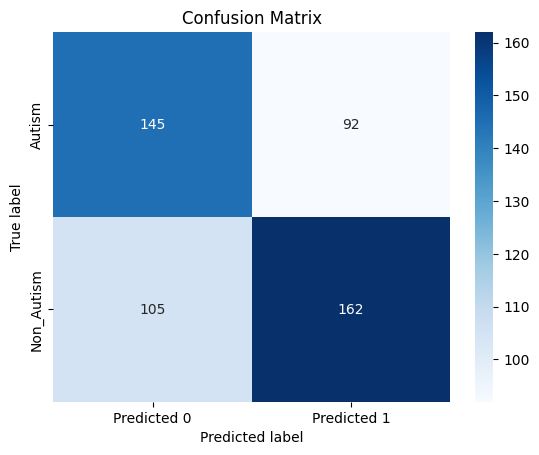

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Autism', 'Non_Autism'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


The model has a decent accuracy of approximately 81.43%. It performs better at predicting autistic individuals compared to predicting non-autistic individuals.

#### **4.1.4 Make Predictions**



In [ ]:
import cv2
import dlib
import numpy as np

# Function to compute the distance between two points
def compute_distance(landmarks, point1, point2):
    x1, y1 = landmarks.part(point1).x, landmarks.part(point1).y
    x2, y2 = landmarks.part(point2).x, landmarks.part(point2).y
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

# Predict function for Machine Learning model
def predict_ML(image_path):
    # Initialize the face detector and landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/gdrive/MyDrive/AutismDataset/shape_predictor_81_face_landmarks.dat")

    # Load and preprocess the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    features_dict = []
    for face in faces:
        # Crop face from image
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        cropped_face = image[y:y+h, x:x+w]
        resized_face = cv2.resize(cropped_face, (224, 224))

        # Detect landmarks
        landmarks = predictor(gray, face)

        # Extract features
        eye_distance = compute_distance(landmarks, 39, 42)
        upper_face_length = compute_distance(landmarks, 27, 71)
        mid_face_height = compute_distance(landmarks, 33, 27)
        mouth_width = compute_distance(landmarks, 51, 33)
        philtrum_length = compute_distance(landmarks, 54, 48)

        features_dict = [eye_distance, upper_face_length, mid_face_height, mouth_width, philtrum_length]

        # Make prediction
        prediction = model.predict_proba(np.array([features_dict]))

        # Get class label and confidence
        CLASS_NAMES = ["Autistic", "Non_Autistic"]
        predicted_class = CLASS_NAMES[np.argmax(prediction[0])]
        confidence = np.max(prediction[0])

        return {
            'class': predicted_class,
            'confidence': float(confidence)
        }


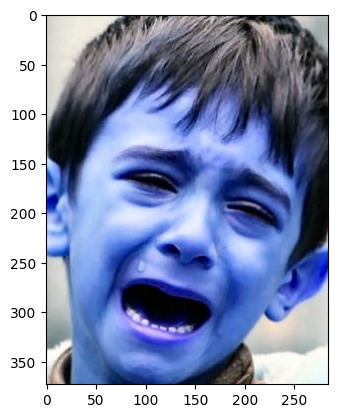

In [ ]:
image_path = '/content/gdrive/MyDrive/0055.jpg'
image = cv2.imread(image_path)
plt.imshow(image)
#plt.imshow(image)

In [ ]:
# Define the image path
image_path = '/content/gdrive/MyDrive/0055.jpg'

# Call the prediction function
result = predict_ML(image_path)

# Extract predicted class and confidence
predicted_class = result['class']
confidence = result['confidence']

# Create a message with the result
message = f'Result: {predicted_class} (Confidence: {confidence*100:.2f}%)'

# Print the message
print(message)


NameError: name 'model' is not defined

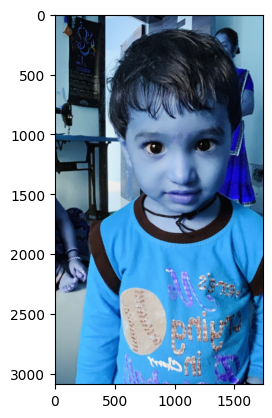

In [ ]:
image_path = 'Non_Autism.jpeg'
image = cv2.imread(image_path)
plt.imshow(image)

In [ ]:
image_path = 'Non_Autism.jpeg'
result = predict_ML(image_path)
predicted_class = result['class']
confidence = result['confidence']
message = f'Result: {predicted_class} (Confidence: {confidence*100:.2f}%)'
print(message)

Result: Non_Autistic (Confidence: 93.10%)


### **4.2 CNN Model**

#### **4.2.1 Split the Dataset into Train, Test, and Validation Sets**

In [ ]:
import os
import shutil
import random

def split_data(input_folder, output_folder, train_ratio=0.86, test_ratio=0.07, val_ratio=0.07):
    # Create destination folders if they do not exist
    for folder in ['Autistic', 'Non_Autistic']:
        os.makedirs(os.path.join(output_folder, 'train', folder), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'test', folder), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'val', folder), exist_ok=True)

    # Get list of all image files in the Autistic folder
    autistic_files = os.listdir(os.path.join(input_folder, 'Autistic'))
    autistic_images = [file for file in autistic_files if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Get list of all image files in the Non_Autistic folder
    non_autistic_files = os.listdir(os.path.join(input_folder, 'Non_Autistic'))
    non_autistic_images = [file for file in non_autistic_files if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Function to move images to train, test, val folders
    def move_images(images, category_folder):
        num_train = int(len(images) * train_ratio)
        num_test = int(len(images) * test_ratio)
        num_val = int(len(images) * val_ratio)

        train_images = random.sample(images, num_train)
        remaining_images = list(set(images) - set(train_images))
        test_images = random.sample(remaining_images, num_test)
        val_images = list(set(remaining_images) - set(test_images))

        for img_name in train_images:
            source_path = os.path.join(input_folder, category_folder, img_name)
            dest_path = os.path.join(output_folder, 'train', category_folder, img_name)
            shutil.copy(source_path, dest_path)

        for img_name in test_images:
            source_path = os.path.join(input_folder, category_folder, img_name)
            dest_path = os.path.join(output_folder, 'test', category_folder, img_name)



In [ ]:
# Path to the folder containing the original images
input_folder = "/content/gdrive/MyDrive/Project_Python_DS/cleanData"

# Path to the folder where the results will be stored
output_folder = "/content/gdrive/MyDrive/Project_Python_DS/DATA"

# Call the function to split the data
split_data(input_folder, output_folder)


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/Project_Python_DS/cleanData/Autistic'

### **4.2.2 Build Prediction Model**

**4.2.2.1. Data Preprocessing**

In [ ]:
WEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
TRAIN_DIR = '/content/gdrive/MyDrive/Project_Python_DS/DATA/train'
TEST_DIR = '/content/gdrive/MyDrive/Project_Python_DS/DATA/test'
VAL_DIR = '/content/gdrive/MyDrive/Project_Python_DS/DATA/val'
lr = 0.001
epoch=50

In [ ]:
def preprocess_data_input(MODEL_NAME, HEIGHT, WIDTH, BATCH_SIZE, TRAIN_DIR, TEST_DIR, VAL_DIR):
    preprocess_input_mapping = {
        "densenet": preprocess_input_densenet,
        "resnet": preprocess_input_resnet,
        "vgg16": preprocess_input_vgg16,
        "mobilenet": preprocess_input_mobilenet,
        "efficientnet": preprocess_input_efficientnet,
        "inception": preprocess_input_inception
    }

    # Create an ImageDataGenerator instance for data augmentation and preprocessing
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_mapping[MODEL_NAME],  # Apply model-specific preprocessing
        rotation_range=90,  # Randomly rotate images by up to 90 degrees
        horizontal_flip=True,  # Randomly flip images horizontally
        vertical_flip=True  # Randomly flip images vertically
    )

    # Generate batches of augmented data for training
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(HEIGHT, WIDTH),  # Resize images to specified height and width
        batch_size=BATCH_SIZE,  # Number of images to return in each batch
        color_mode='rgb',  # Color mode for images
        class_mode='categorical',  # Use categorical labels
        shuffle=True  # Shuffle images
    )

    # Generate batches of data for testing
    test_generator = train_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False  # Do not shuffle test data
    )

    # Generate batches of data for validation
    val_generator = train_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False  # Do not shuffle validation data
    )

    return train_generator, test_generator, val_generator


#### **4.2.2.2. Build Callback Function**

In [ ]:
class LRA(Callback):
    def __init__(self, model, test_generator, csv_filename, epochs=50, patience=2, threshold=.95, factor=.5):
        super(LRA, self).__init__()
        self.model_instance = model
        #self.model = model
        self.patience = patience
        self.threshold = threshold
        self.factor = factor
        #self.lr = float(keras.backend.get_value(self.model.optimizer.lr))
        #self.lr = float(tf.keras.backend.get_value(self.model.lr))  # Updated line
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.count = 0
        self.test_generator = test_generator
        self.train_history = {'Epoch': [], 'Train Loss': [], 'Train Accuracy': []}
        self.val_history = {'Epoch': [], 'Validation Loss': [], 'Validation Accuracy': []}
        self.csv_filename = csv_filename
        self.num_epochs = 0
        self.epochs = epochs
        msg = 'Starting Training - Initializing Custom Callback'
        print(msg)

    def check_and_export_csv(self):
        if self.num_epochs == self.epochs:
            self.export_history_to_csv()

    def write_val_history(self, epoch, val_loss, val_accuracy):
        self.val_history['Epoch'].append(epoch)
        self.val_history['Validation Loss'].append(val_loss)
        self.val_history['Validation Accuracy'].append(val_accuracy)

    def write_train_history(self, epoch, train_loss, train_accuracy):
        self.train_history['Epoch'].append(epoch)
        self.train_history['Train Loss'].append(train_loss)
        self.train_history['Train Accuracy'].append(train_accuracy)

    def export_history_to_csv(self):
        train_df = pd.DataFrame(self.train_history)
        val_df = pd.DataFrame(self.val_history)
        test_df = pd.DataFrame(self.test_metrics)

        result_df = pd.merge(train_df, val_df, on='Epoch')
        result_df = pd.merge(result_df, test_df, on='Epoch')

        result_df.to_csv(self.csv_filename, index=False)

    def on_epoch_end(self, epoch, logs=None):
        """

        Args:
          epoch:
          logs:
        """
        #lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        v_loss = logs.get('val_loss')
        acc = logs.get('accuracy')

        if acc < self.threshold:
            if acc > self.highest_tracc:
                msg = f'\nTraining accuracy improved from {self.highest_tracc:7.2f} to {acc:7.2f}, learning rate held at {lr:9.6f}'
                self.highest_tracc = acc
                self.model.best_weights = self.model.get_weights()
                self.count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
            else:
                if self.count >= self.patience - 1:
                    self.lr = lr * self.factor
                    keras.backend.set_value(self.model.optimizer.lr, self.lr)
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                    msg = f'\nFor epoch {epoch + 1}, training accuracy did not improve for {self.patience} consecutive epochs, learning rate adjusted to {lr:9.6f}'
                    print(msg)
                else:
                    self.count += 1
                    msg = f'\nFor epoch {epoch + 1}, training accuracy did not improve, patience count incremented to {self.count}'
                    print(msg)
        else:
            if v_loss < self.lowest_vloss:
                msg = f'\nFor epoch {epoch + 1}, validation loss improved from {self.lowest_vloss:7.4f} to {v_loss:7.4f}, saving best weights'
                print(msg)
                self.lowest_vloss = v_loss
                self.model.best_weights = self.model.get_weights()
                self.count = 0
            else:
                if self.count >= self.patience - 1:
                    self.lr = self.lr * self.factor
                    msg = f'\nFor epoch {epoch + 1}, validation loss failed to improve for {self.patience} consecutive epochs, learning rate adjusted to {self.lr:9.6f}'
                    self.count = 0
                    print(msg)
                    keras.backend.set_value(self.model.optimizer.lr, self.lr)
                else:
                    self.count += 1
                    msg = f'\nFor epoch {epoch + 1}, validation loss did not improve, patience count incremented to {self.count}'
                    print(msg)

        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')
        train_loss = logs.get('loss')
        train_accuracy = logs.get('accuracy')

        self.write_train_history(epoch + 1, train_loss, train_accuracy)
        self.write_val_history(epoch + 1, val_loss, val_accuracy)

        self.num_epochs += 1
        self.check_and_export_csv()


In [ ]:
from tensorflow.keras.applications import InceptionV3, MobileNet, DenseNet201, EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, MobileNet, DenseNet201, EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Define a function to create models
def create_model(model_name):
    #if model_name == 'InceptionV3':
     #   base_model = InceptionV3(weights='imagenet', include_top=False)
    #elif model_name == 'MobileNet':
     #   base_model = MobileNet(weights='imagenet', include_top=False)
    #elif model_name == 'DenseNet201':
     #   base_model = DenseNet201(weights='imagenet', include_top=False)
    if model_name == 'EfficientNetB3':
        base_model = EfficientNetB3(weights='imagenet', include_top=False)
    else:
        raise ValueError("Unsupported model type")

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')  # 1 unit for binary classification with sigmoid activation
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # binary_crossentropy for binary classification
    return model

# Load data
def load_data(batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    train_data = datagen.flow_from_directory('/content/gdrive/MyDrive/AutismDataset/consolidated', batch_size=batch_size, class_mode='binary')
    validation_data = datagen.flow_from_directory('/content/gdrive/MyDrive/AutismDataset/valid', batch_size=batch_size, class_mode='binary')
    test_data = datagen.flow_from_directory('/content/gdrive/MyDrive/AutismDataset/test', batch_size=batch_size, class_mode='binary')

    return train_data, validation_data, test_data

# Train and evaluate models
def train_and_evaluate(model_name, train_data, validation_data, test_data):
    model = create_model(model_name)
    history = model.fit(
        train_data,
        epochs=10,
        validation_data=validation_data,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )


    # Save training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'{model_name}_training_history.csv', index=False)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(test_data)
    y_pred = model.predict(test_data)
    y_true = test_data.classes
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary class predictions
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_true, y_pred_classes, target_names=["Non Autism", "Autism"]))

    return test_accuracy, history_df

# Main function to run the training and evaluation
def main():
    train_data, validation_data, test_data = load_data()
    num_classes = 1  # For binary classification, we have two classes but the output is one sigmoid unit

    results = {}
    #'InceptionV3', 'MobileNet', 'DenseNet201',
    models = ['EfficientNetB3']

    for model_name in models:
        print(f"Training and evaluating {model_name}...")
        accuracy, history_df = train_and_evaluate(model_name, train_data, validation_data, test_data)
        results[model_name] = {
            'accuracy': accuracy,
            'history': history_df
        }

    # Compare results
    for model_name, result in results.items():
        print(f"{model_name} - Accuracy: {result['accuracy']:.4f}")

if __name__ == "__main__":
    main()


Found 2939 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Training and evaluating EfficientNetB3...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 2700s 28s/step - accuracy: 0.7375 - loss: 0.5387 - val_accuracy: 0.5000 - val_loss: 0.9020
Epoch 2/10
11/92 ━━━━━━━━━━━━━━━━━━━━ 36:10 27s/step - accuracy: 0.8305 - loss: 0.3490

KeyboardInterrupt: 

**Perform custom training for each model: InceptionV3, MobileNet, DenseNet201, EfficientNetB3. Then, evaluate and compare the results of these models.**

In [ ]:
model_efficientNet = load_model('/content/gdrive/MyDrive/AutismDataset/model&csv/EfficientNetB3_model.h5')

TypeError: load_model() got an unexpected keyword argument 'optimizer'

In [ ]:
history_densNet = pd.read_csv('/content/gdrive/MyDrive/AutismDataset/model&csv/DenseNet201_training_history.csv')
history_efficientNet = pd.read_csv('/content/gdrive/MyDrive/AutismDataset/model&csv/EfficientNetB3_training_history.csv')
history_inception = pd.read_csv('/content/gdrive/MyDrive/AutismDataset/model&csv/InceptionV3_training_history.csv')
history_mobilenet = pd.read_csv('/content/gdrive/MyDrive/AutismDataset/model&csv/MobileNet_training_history.csv')
model_densNet = load_model('/content/gdrive/MyDrive/AutismDataset/model&csv/DenseNet201_model.h5')
model_efficientNet = load_model('/content/gdrive/MyDrive/AutismDataset/model&csv/EfficientNetB3_model.h5')
model_inception = load_model('/content/gdrive/MyDrive/AutismDataset/model&csv/InceptionV3_model.h5')
model_mobilenet = load_model('/content/gdrive/MyDrive/AutismDataset/model&csv/MobileNet_model.h5')

ValueError: Layer "dense_2" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 8, 8, 1920), dtype=float32, sparse=False, name=keras_tensor_6761>, <KerasTensor shape=(None, 8, 8, 1920), dtype=float32, sparse=False, name=keras_tensor_6762>]

In [ ]:
dfs = [history_densNet, history_efficientNet, history_inception, history_mobilenet]
CNN_name = ['DenseNet', 'EfficientNet', 'Inception', 'MobileNet']
colors = ['b', 'g', 'r', 'y']

# First plot (loss and val_loss)
plt.figure(figsize=(10, 5))
for i, (df, color) in enumerate(zip(dfs, colors)):
    plt.plot(df.index, df['Train Loss'], color=color, linestyle='-', label=f'{CNN_name[i]}_loss')
    plt.plot(df.index, df['Validation Loss'], color=color, linestyle='--', label=f'{CNN_name[i]}_val_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Second plot (accuracy and val_accuracy)
plt.figure(figsize=(10, 5))
for i, (df, color) in enumerate(zip(dfs, colors)):
    plt.plot(df.index, df['Train Accuracy'], color=color, linestyle='-', label=f'{CNN_name[i]}_accuracy')
    plt.plot(df.index, df['Validation Accuracy'], color=color, linestyle='--', label=f'{CNN_name[i]}_val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


KeyError: 'Train Loss'

<Figure size 1000x500 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define preprocessing functions for different models
def preprocess_data_input(MODEL_NAME, HEIGHT, WIDTH, BATCH_SIZE, VAL_DIR):
    preprocess_input_mapping = {
        "densNet": preprocess_input_densenet,
        "resNet": preprocess_input_resnet,
        "inception": preprocess_input_inception,
        "mobilenet": preprocess_input_mobilenet,
        "efficientNet": preprocess_input_efficientnet,
    }
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_mapping[MODEL_NAME],
    )
    val_generator = train_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False
    )
    return val_generator

# Model names and corresponding history and models
CNN_name = ['densNet', 'efficientNet', 'inception', 'mobilenet']

# Create test generators for each model
test_generator = []
for model_name in CNN_name:
    test_generator.append(preprocess_data_input(model_name, 224, 224, 32, 'D:\\Py for data science\\final project\\autism\\archive\\AutismDataset\\test_fake'))

# Histories and models
historys = {
    'densNet': history_densNet,
    'efficientNet': history_efficientNet,
    'inception': history_inception,
    'mobilenet': history_mobilenet,
}
models = {
    'densNet': model_densNet,
    'efficientNet': model_efficientNet,
    'inception': model_inception,
    'mobilenet': model_mobilenet,
}

# Define DataFrame to store results
results = pd.DataFrame(columns=[
    'Model', 'Train Loss', 'Train Accuracy',
    'Validation Loss', 'Validation Accuracy',
    'Accuracy', 'Precision', 'Recall', 'F1-Score'
])

# Iterate over each model to compute and store results
for model_name, history_name in zip(models, historys):
    # Perform prediction and compute evaluation metrics
    y_pred = models[model_name].predict(test_generator[CNN_name.index(model_name)])  # Replace with your actual prediction function
    y_pred_binary = np.argmax(y_pred, axis=1)
    y_true = test_generator[CNN_name.index(model_name)].classes
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, average='weighted')
    recall = recall_score(y_true, y_pred_binary, average='weighted')
    f1 = f1_score(y_true, y_pred_binary, average='weighted')

    # Get the last row of training history
    last_row = historys[history_name].iloc[-1]

    # Append results to the DataFrame
    results = results.append({
        'Model': model_name,
        'Train Loss': last_row['Train Loss'],
        'Train Accuracy': last_row['Train Accuracy'],
        'Validation Loss': last_row['Validation Loss'],
        'Validation Accuracy': last_row['Validation Accuracy'],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, ignore_index=True)

print(results)


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Py for data science\\final project\\autism\\archive\\AutismDataset\\test_fake'

In [ ]:
results

NameError: name 'results' is not defined

**4.2.2.3. Fine-tuning the EfficientNetB3 Model**

The EfficientNetB3 model is used with specific custom parameters to address the image classification problem.

The model is initialized with pre-trained weights on ImageNet and configured for retraining (`trainable=True`).

For the architecture, I added a fully connected layer with 256 units, using the ReLU activation function to enhance the model's learning capability. I applied an L2 regularizer with a coefficient of 0.016 to the kernel weights to control their values and prevent overfitting. Additionally, I used an L1 regularizer with a coefficient of 0.006 on both the activation values of the layer and the bias weights.

To stabilize the training process, I included a Dropout layer with a rate of 0.4 to reduce overfitting.

Finally, the output layer is set with 2 units and a softmax activation function to align with the binary classification problem. I configured the model to be retrainable to optimize performance on the custom data.

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def efficientNetB3():
    # Load the base EfficientNetB3 model with pre-trained weights and without the top classification layer
    base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')

    # Set the base model to be trainable
    base_model.trainable = True

    # Add custom layers on top of the base model
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006),
              activation='relu')(x)
    x = Dropout(rate=0.4, seed=123)(x)
    output = Dense(1, activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)

    return model


In [ ]:
efficientNet = efficientNetB3()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
efficientNet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 11,183,408 (42.66 MB)

 Trainable params: 11,093,033 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
adam = Adam(learning_rate=0.001)
efficientNet.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
HEIGHT,

NameError: name 'HEIGHT' is not defined

In [ ]:
VAL_DIR =   '/content/gdrive/MyDrive/AutismDataset/valid'


In [ ]:
TRAIN_DIR ='/content/gdrive/MyDrive/AutismDataset/consolidated'

In [ ]:
TEST_DIR='/content/gdrive/MyDrive/AutismDataset/test'
HEIGHT=None

In [ ]:
WEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
TRAIN_DIR = '/content/gdrive/MyDrive/Project_Python_DS/DATA/train'
TEST_DIR = '/content/gdrive/MyDrive/Project_Python_DS/DATA/test'
VAL_DIR = '/content/gdrive/MyDrive/Project_Python_DS/DATA/val'
learning_rate = 0.001
epoch=50

In [ ]:
train_generator, test_generator, val_generator = preprocess_data_input('efficientnet', HEIGHT, WIDTH, BATCH_SIZE, TRAIN_DIR, TEST_DIR, VAL_DIR)


Found 2939 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:


train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/AutismDataset/consolidated',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # or 'categorical' for multi-class
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/AutismDataset/valid',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2939 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

class LRA(Callback):
    def __init__(self, model, test_generator, csv_filename, epochs=50, patience=2, threshold=.95, factor=.5):
        super(LRA, self).__init__()
        self.model_instance = model
        self.patience = patience
        self.threshold = threshold
        self.factor = factor
        self.lr = float(tf.keras.backend.get_value(self.model_instance.optimizer.learning_rate))  # Changed to learning_rate
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.count = 0
        self.test_generator = test_generator
        self.train_history = {'Epoch': [], 'Train Loss': [], 'Train Accuracy': []}
        self.val_history = {'Epoch': [], 'Validation Loss': [], 'Validation Accuracy': []}
        self.csv_filename = csv_filename
        self.num_epochs = 0
        self.epochs = epochs
        print('Starting Training - Initializing Custom Callback')

    def check_and_export_csv(self):
        if self.num_epochs == self.epochs:
            self.export_history_to_csv()

    def write_val_history(self, epoch, val_loss, val_accuracy):
        self.val_history['Epoch'].append(epoch)
        self.val_history['Validation Loss'].append(val_loss)
        self.val_history['Validation Accuracy'].append(val_accuracy)

    def write_train_history(self, epoch, train_loss, train_accuracy):
        self.train_history['Epoch'].append(epoch)
        self.train_history['Train Loss'].append(train_loss)
        self.train_history['Train Accuracy'].append(train_accuracy)

    def export_history_to_csv(self):
        train_df = pd.DataFrame(self.train_history)
        val_df = pd.DataFrame(self.val_history)
        result_df = pd.merge(train_df, val_df, on='Epoch')
        result_df.to_csv(self.csv_filename, index=False)

    def on_epoch_end(self, epoch, logs=None):
        v_loss = logs.get('val_loss')
        acc = logs.get('accuracy')

        if acc < self.threshold:
            if acc > self.highest_tracc:
                msg = f'\nTraining accuracy improved from {self.highest_tracc:.2f} to {acc:.2f}, learning rate held at {self.lr:.6f}'
                self.highest_tracc = acc
                #self.model_instance.set_weights(self.model_instance.best_weights)
                self.count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
            else:
                if self.count >= self.patience - 1:
                    self.lr *= self.factor
                    tf.keras.backend.set_value(self.model_instance.optimizer.learning_rate, self.lr)  # Changed to learning_rate
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                    msg = f'\nFor epoch {epoch + 1}, training accuracy did not improve for {self.patience} consecutive epochs, learning rate adjusted to {self.lr:.6f}'
                    print(msg)
                else:
                    self.count += 1
                    msg = f'\nFor epoch {epoch + 1}, training accuracy did not improve, patience count incremented to {self.count}'
                    print(msg)
        else:
            if v_loss < self.lowest_vloss:
                msg = f'\nFor epoch {epoch + 1}, validation loss improved from {self.lowest_vloss:.4f} to {v_loss:.4f}, saving best weights'
                print(msg)
                self.lowest_vloss = v_loss
                self.model_instance.best_weights = self.model_instance.get_weights()
                self.count = 0
            else:
                if self.count >= self.patience - 1:
                    self.lr *= self.factor
                    msg = f'\nFor epoch {epoch + 1}, validation loss failed to improve for {self.patience} consecutive epochs, learning rate adjusted to {self.lr:.6f}'
                    self.count = 0
                    print(msg)
                    tf.keras.backend.set_value(self.model_instance.optimizer.learning_rate, self.lr)  # Changed to learning_rate
                else:
                    self.count += 1
                    msg = f'\nFor epoch {epoch + 1}, validation loss did not improve, patience count incremented to {self.count}'
                    print(msg)

        train_loss = logs.get('loss')
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        self.write_train_history(epoch + 1, train_loss, train_accuracy)
        self.write_val_history(epoch + 1, v_loss, val_accuracy)

        self.num_epochs += 1
        self.check_and_export_csv()


In [ ]:
results = efficientNet.fit(x=train_generator, epochs=10,
                       validation_data=val_generator,
                      validation_steps=val_generator.samples//BATCH_SIZE,
                      shuffle=True, callbacks=[LRA(model = efficientNet, test_generator = test_generator, csv_filename = "/content/EfficientNetB3_training_history.csv")])

NameError: name 'efficientNet' is not defined

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.applications import EfficientNetB3

# Model definition
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # One output for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
results = efficientNet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    shuffle=True,
    callbacks=[LRA(model=efficientNet, test_generator=test_generator, csv_filename="/content/EfficientNetB3_training_history.csv")]
)


Starting Training - Initializing Custom Callback


TypeError: 'tuple' object cannot be interpreted as an integer

In [ ]:
test_loss, test_accuracy = efficientNet.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred = efficientNet.predict(test_generator)
y_true = test_generator.classes

# Convert probabilities to class labels
y_pred_binary = np.argmax(y_pred, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(y_true, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_binary))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'efficientNet' is not defined

The performance evaluation of the convolutional neural network (CNN) model is significantly higher compared to the XGBoost model. This could be due to the model's greater learning capability and the use of image data, which allows for the optimization of features in the dataset.

In [ ]:
efficientNet.save('/content/gdrive/MyDrive/AutismDataset/model&csv/DenseNet201_model.h5')

NameError: name 'efficientNet' is not defined

#### **4.2.3 Making Predictions**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# Initialize the face detector (e.g., using dlib or another library)
import dlib
detector = dlib.get_frontal_face_detector()

# Load the pre-trained EfficientNet model
efficientNet = EfficientNetB3(weights='imagenet')

def predict_DL(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at the path: {image_path}")

    # Detect faces in the image
    faces = detector(image)
    if len(faces) == 0:
        return {'class': 'No face detected', 'confidence': None}

    # Process the first detected face
    face = faces[0]
    x, y, w, h = face.left(), face.top(), face.width(), face.height()

    # Crop and resize the face
    cropped_face = image[y:y+h, x:x+w]
    resized_face = cv2.resize(cropped_face, (300, 300))

    # Preprocess the image for EfficientNet
    img = preprocess_input(resized_face)
    img = np.expand_dims(img, axis=0)

    # Make predictions
    prediction = efficientNet.predict(img)

    # Print the shape and content of the prediction
    print(f"Prediction shape: {prediction.shape}")
    print(f"Prediction values: {prediction}")

    # For EfficientNetB3 with ImageNet weights, you need to map the predictions to 1000 ImageNet classes
    # Instead of using a custom CLASS_NAMES, you should use the ImageNet class labels
    # Here, using a dummy example as placeholder:
    CLASS_NAMES = ["Class " + str(i) for i in range(1000)]  # Dummy class names for demonstration

    # Get the predicted class and confidence
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = CLASS_NAMES[predicted_class_index]
    confidence = np.max(prediction[0])

    return {
        'class': predicted_class,
        'confidence': float(confidence)
    }



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction shape: (1, 1000)
Prediction values: [[5.81468572e-04 6.82055834e-04 1.28707616e-04 1.19811935e-04
  2.90618569e-04 2.36412307e-04 7.60264084e-05 8.94828918e-05
  2.86631985e-04 1.11906375e-04 1.98510475e-04 7.97941830e-05
  6.03497392e-05 4.17586743e-05 1.95055880e-04 2.74750171e-04
  1.12326903e-04 8.87339629e-05 5.96938989e-05 3.09081552e-05
  4.89055761e-04 9.09776834e-04 3.02378263e-04 5.58111096e-05
  1.55828558e-04 1.44831632e-04 3.05575348e-04 2.63336900e-04
  1.97406815e-04 3.35466932e-04 2.61641777e-04 4.80242597e-05
  7.57053494e-04 3.04739980e-04 1.03878127e-04 2.19486770e-04
  9.98549876e-05 8.77794664e-05 1.22802419e-04 1.23062928e-04
  3.46881934e-05 1.65794409e-04 1.00581172e-04 3.38872778e-04
  7.61231204e-05 2.65521358e-05 4.63940778e-05 1.88489474e-04
  2.28421835e-04 1.89784638e-04 1.23743259e-04 9.54861025e-05
  1.41044307e-04 1.53690751e-04 1.82805539e-04 5.86008719e-05
  1.74579458e-04 1.22704849e-04 1.40074742e-04 9.

In [ ]:
def predict_DL(image_path):

    image = cv2.imread(image_path)
    faces = detector(image)

    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()

        cropped_face = image[y:y+h, x:x+w]

        resized_frame = cv2.resize(cropped_face, (300, 300))
        img = keras.applications.efficientnet.preprocess_input(resized_frame)
        img = np.expand_dims(img, axis=0)

        prediction = efficientNet.predict(img)

        CLASS_NAMES = ["Autistic", "Non_Autistic"]
        predicted_class = CLASS_NAMES[np.argmax(prediction[0])]
        confidence = np.max(prediction[0])

        return {
            'class': predicted_class,
            'confidence': float(confidence)
        }


In [ ]:
result = predict_DL('Autism.jpg')
predicted_class = result['class']
confidence = result['confidence']
message = f'Result: {predicted_class} (Confidence: {confidence*100:.2f}%)'
print(message)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Prediction shape: (1, 1000)
Prediction values: [[5.81468572e-04 6.82055834e-04 1.28707616e-04 1.19811935e-04
  2.90618569e-04 2.36412307e-04 7.60264084e-05 8.94828918e-05
  2.86631985e-04 1.11906375e-04 1.98510475e-04 7.97941830e-05
  6.03497392e-05 4.17586743e-05 1.95055880e-04 2.74750171e-04
  1.12326903e-04 8.87339629e-05 5.96938989e-05 3.09081552e-05
  4.89055761e-04 9.09776834e-04 3.02378263e-04 5.58111096e-05
  1.55828558e-04 1.44831632e-04 3.05575348e-04 2.63336900e-04
  1.97406815e-04 3.35466932e-04 2.61641777e-04 4.80242597e-05
  7.57053494e-04 3.04739980e-04 1.03878127e-04 2.19486770e-04
  9.98549876e-05 8.77794664e-05 1.22802419e-04 1.23062928e-04
  3.46881934e-05 1.65794409e-04 1.00581172e-04 3.38872778e-04
  7.61231204e-05 2.65521358e-05 4.63940778e-05 1.88489474e-04
  2.28421835e-04 1.89784638e-04 1.23743259e-04 9.54861025e-05
  1.41044307e-04 1.53690751e-04 1.82805539e-04 5.86008719e-05
  1.74579458e-04 1.22704849e-04 1.40074742e-04

In [ ]:
result = predict_DL('Non_Autism.jpg')
predicted_class = result['class']
confidence = result['confidence']
message = f'Result: {predicted_class} (Confidence: {confidence*100:.2f}%)'
print(message)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Prediction shape: (1, 1000)
Prediction values: [[7.79206981e-04 9.18689009e-04 1.72779444e-04 9.78128155e-05
  1.40445176e-04 5.51400823e-04 1.02801969e-04 4.76713467e-05
  2.14510001e-04 1.21525591e-04 8.84233858e-04 9.19806262e-05
  1.27386564e-04 1.63257311e-04 4.93743632e-04 2.25370401e-04
  2.25425538e-04 1.37065566e-04 6.50740840e-05 6.85382765e-05
  3.59713507e-04 5.86011447e-04 2.15862368e-04 7.30590837e-05
  1.47473882e-04 8.41649089e-05 2.81942397e-04 5.69426105e-04
  2.58752407e-04 7.04059610e-04 2.83423520e-04 7.30127649e-05
  8.58997111e-04 4.84029471e-04 9.79252000e-05 3.63169238e-04
  1.98172536e-04 1.18182979e-04 1.02368336e-04 6.70854424e-05
  6.87198626e-05 8.13767401e-05 1.21164638e-04 3.56797304e-04
  8.63296809e-05 3.62424144e-05 7.72394051e-05 4.16246359e-04
  8.63211972e-05 1.37897601e-04 1.93023559e-04 1.47469938e-04
  1.17958683e-04 1.35550188e-04 2.27796700e-04 1.41849669e-04
  1.98464826e-04 8.33159938e-05 1.05732441e-04

#**Conclusion**

The dataset used was collected from sources on social media and was not provided by any specific organization or entity, so the data may be inconsistent and not necessarily representative of real-world conditions. Additionally, external factors such as lighting and camera angles can impact the performance of the model.

This can significantly affect the final performance of the model due to the complexity of the training process and the uncertainty about the quality of the data, making the optimization process more challenging. Uncertainty about the quality and accuracy of the data is an important factor to consider when evaluating the model's results.

However, with a 90% accuracy on this dataset, detecting autism in children through facial recognition is entirely feasible and promising for yielding positive results.

# **Application**

To facilitate the use and application of the developed model, the team has implemented the model into web interfaces, Tinker, and real-time OpenCV applications for capturing images directly from a webcam for prediction. [API](https://drive.google.com/drive/folders/1wel8dJbsEaqckra_p41FLbuLJq_w5jxs?usp=sharing)

- **Web Interface**: The team has integrated the model into a basic web interface, which can be referred to as a web application or website that users can access through their browsers. Users can upload images from their computers or use a webcam to capture images, and the model will make predictions based on the data.

- **Tinker**: Tinker may refer to a development environment (IDE) or an application developed using Python GUI libraries such as Tkinter. In this case, it could be a simple application with a graphical user interface to interact with the model.

- **Real-time OpenCV**: Using OpenCV to capture images from a webcam and feed those images directly into the model for prediction. This can be done in real time, allowing for immediate recognition and prediction from images captured by the webcam without the need to store the images.